In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam

tf.compat.v1.enable_eager_execution()

In [35]:
df = pd.read_csv('cancer_classification.csv')


In [36]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nTarget distribution:")
print(df['benign_0__mal_1'].value_counts())

Dataset shape: (569, 31)

First few rows:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  wor

In [37]:
X = df.drop('benign_0__mal_1', axis=1)
y = df['benign_0__mal_1']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (364, 30)
Validation set: (91, 30)
Test set: (114, 30)


In [40]:
def create_model(activation_function='relu', optimizer='adam'):
    model = keras.Sequential([
        layers.Dense(64, activation=activation_function, input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(32, activation=activation_function),
        layers.Dropout(0.3),
        layers.Dense(16, activation=activation_function),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

activation_functions = ['relu', 'sigmoid', 'tanh', 'elu', 'leaky_relu']
optimizers = {
    'adam': Adam(learning_rate=0.001),
    'sgd': SGD(learning_rate=0.01, momentum=0.9),
    'rmsprop': RMSprop(learning_rate=0.001),
    'adagrad': Adagrad(learning_rate=0.01),
    'nadam': Nadam(learning_rate=0.001)
}

In [41]:
results = {}
history_data = {}

for activation in activation_functions:
    for opt_name, optimizer in optimizers.items():
        print(f"\nTraining model with {activation} activation and {opt_name} optimizer...")

        model_name = f"{activation}_{opt_name}"
        if opt_name == 'adam':
            current_optimizer = Adam(learning_rate=0.001)
        elif opt_name == 'sgd':
            current_optimizer = SGD(learning_rate=0.01, momentum=0.9)
        elif opt_name == 'rmsprop':
            current_optimizer = RMSprop(learning_rate=0.001)
        elif opt_name == 'adagrad':
            current_optimizer = Adagrad(learning_rate=0.01)
        elif opt_name == 'nadam':
            current_optimizer = Nadam(learning_rate=0.001)
        else:
            current_optimizer = optimizer

        model = create_model(activation_function=activation, optimizer=current_optimizer)


        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=0.0001
        )

        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        history_data[model_name] = history.history

        train_loss, train_accuracy, train_precision, train_recall = model.evaluate(X_train_scaled, y_train, verbose=0)
        val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_val_scaled, y_val, verbose=0)
        test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test_scaled, y_test, verbose=0)

        results[model_name] = {
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'train_precision': train_precision,
            'val_precision': val_precision,
            'test_precision': test_precision,
            'train_recall': train_recall,
            'val_recall': val_recall,
            'test_recall': test_recall,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss
        }

        print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}")


Training model with relu activation and adam optimizer...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


relu_adam - Test Accuracy: 0.9561

Training model with relu activation and sgd optimizer...
relu_sgd - Test Accuracy: 0.9649

Training model with relu activation and rmsprop optimizer...
relu_rmsprop - Test Accuracy: 0.9386

Training model with relu activation and adagrad optimizer...
relu_adagrad - Test Accuracy: 0.9649

Training model with relu activation and nadam optimizer...
relu_nadam - Test Accuracy: 0.9561

Training model with sigmoid activation and adam optimizer...
sigmoid_adam - Test Accuracy: 0.9561

Training model with sigmoid activation and sgd optimizer...
sigmoid_sgd - Test Accuracy: 0.9737

Training model with sigmoid activation and rmsprop optimizer...
sigmoid_rmsprop - Test Accuracy: 0.9649

Training model with sigmoid activation and adagrad optimizer...
sigmoid_adagrad - Test Accuracy: 0.8860

Training model with sigmoid activation and nadam optimizer...
sigmoid_nadam - Test Accuracy: 0.9561

Training model with tanh activation and adam optimizer...
tanh_adam - Test

Top 5 Performing Models:
                 test_accuracy  test_precision  test_recall
sigmoid_sgd           0.973684        0.985915     0.972222
sigmoid_rmsprop       0.964912        0.985714     0.958333
relu_sgd              0.964912        0.985714     0.958333
relu_adagrad          0.964912        0.985714     0.958333
elu_sgd               0.964912        0.985714     0.958333


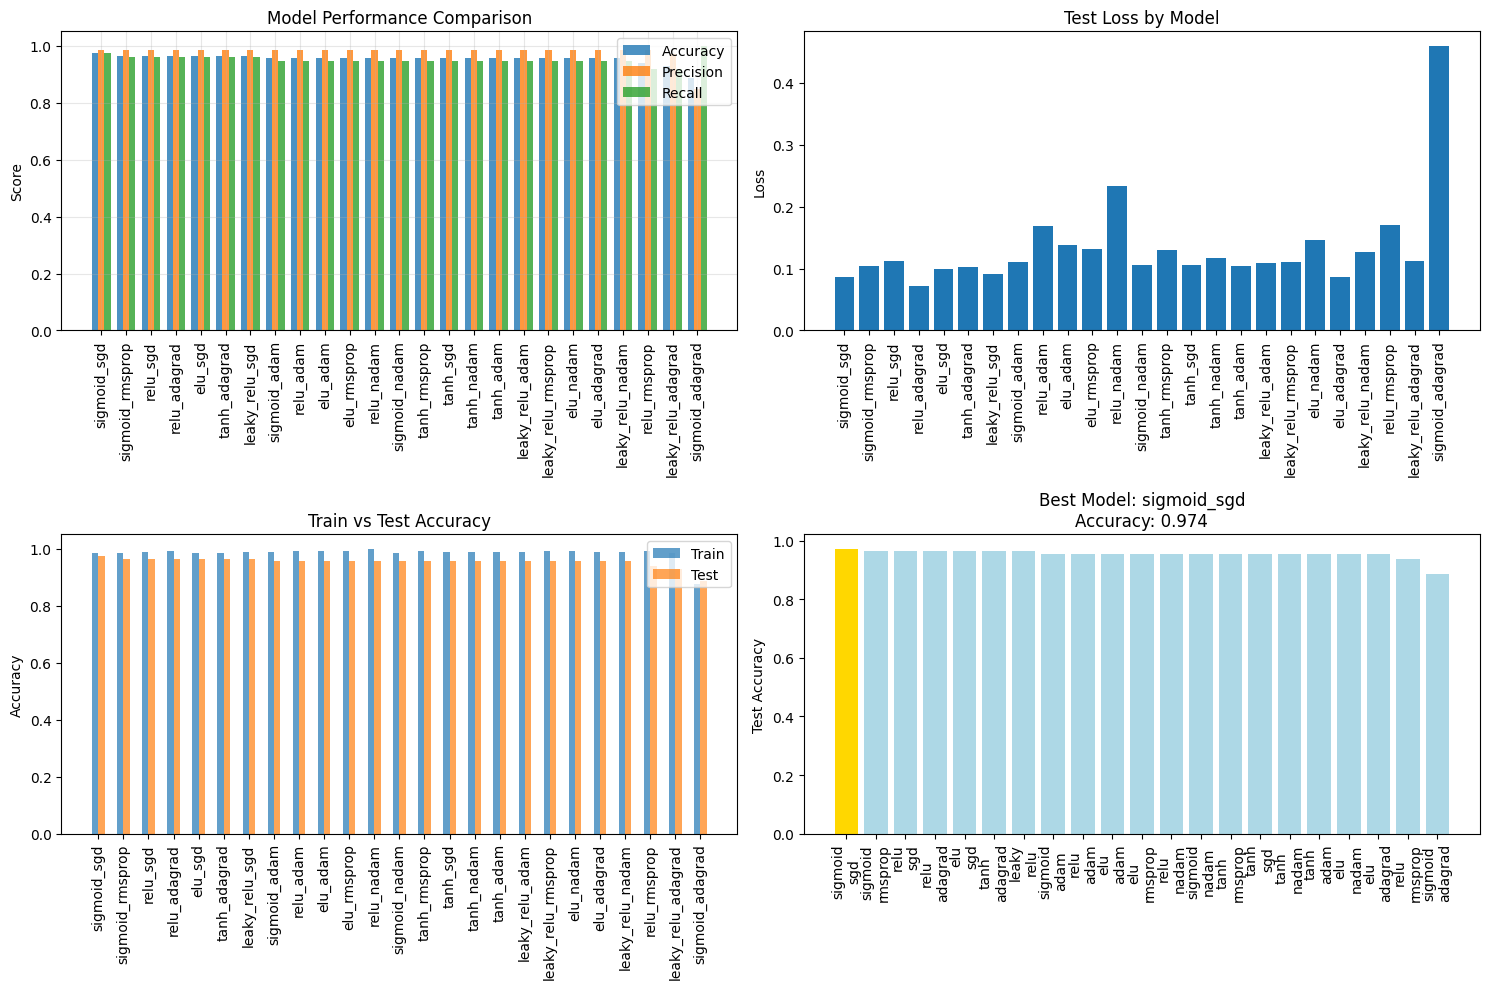

In [42]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('test_accuracy', ascending=False)

print("Top 5 Performing Models:")
print("=" * 50)
print(results_df[['test_accuracy', 'test_precision', 'test_recall']].head())

plt.figure(figsize=(15, 10))

# 1. Main performance metrics in one plot
plt.subplot(2, 2, 1)
x_pos = np.arange(len(results_df))
width = 0.25

plt.bar(x_pos - width, results_df['test_accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x_pos, results_df['test_precision'], width, label='Precision', alpha=0.8)
plt.bar(x_pos + width, results_df['test_recall'], width, label='Recall', alpha=0.8)

plt.xticks(x_pos, results_df.index, rotation=90)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Test loss comparison
plt.subplot(2, 2, 2)
plt.bar(results_df.index, results_df['test_loss'])
plt.title('Test Loss by Model')
plt.xticks(rotation=90)
plt.ylabel('Loss')

# 3. Train vs Test accuracy
plt.subplot(2, 2, 3)
plt.bar(x_pos - width/2, results_df['train_accuracy'], width, label='Train', alpha=0.7)
plt.bar(x_pos + width/2, results_df['test_accuracy'], width, label='Test', alpha=0.7)
plt.xticks(x_pos, results_df.index, rotation=90)
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.legend()

# 4. Best model highlight
plt.subplot(2, 2, 4)
best_model = results_df.index[0]
best_accuracy = results_df.loc[best_model, 'test_accuracy']

models_simple = [name.split('_')[0] + '\n' + name.split('_')[1] for name in results_df.index]
colors = ['lightblue' if model != best_model else 'gold' for model in results_df.index]

plt.bar(models_simple, results_df['test_accuracy'], color=colors)
plt.title(f'Best Model: {best_model}\nAccuracy: {best_accuracy:.3f}')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

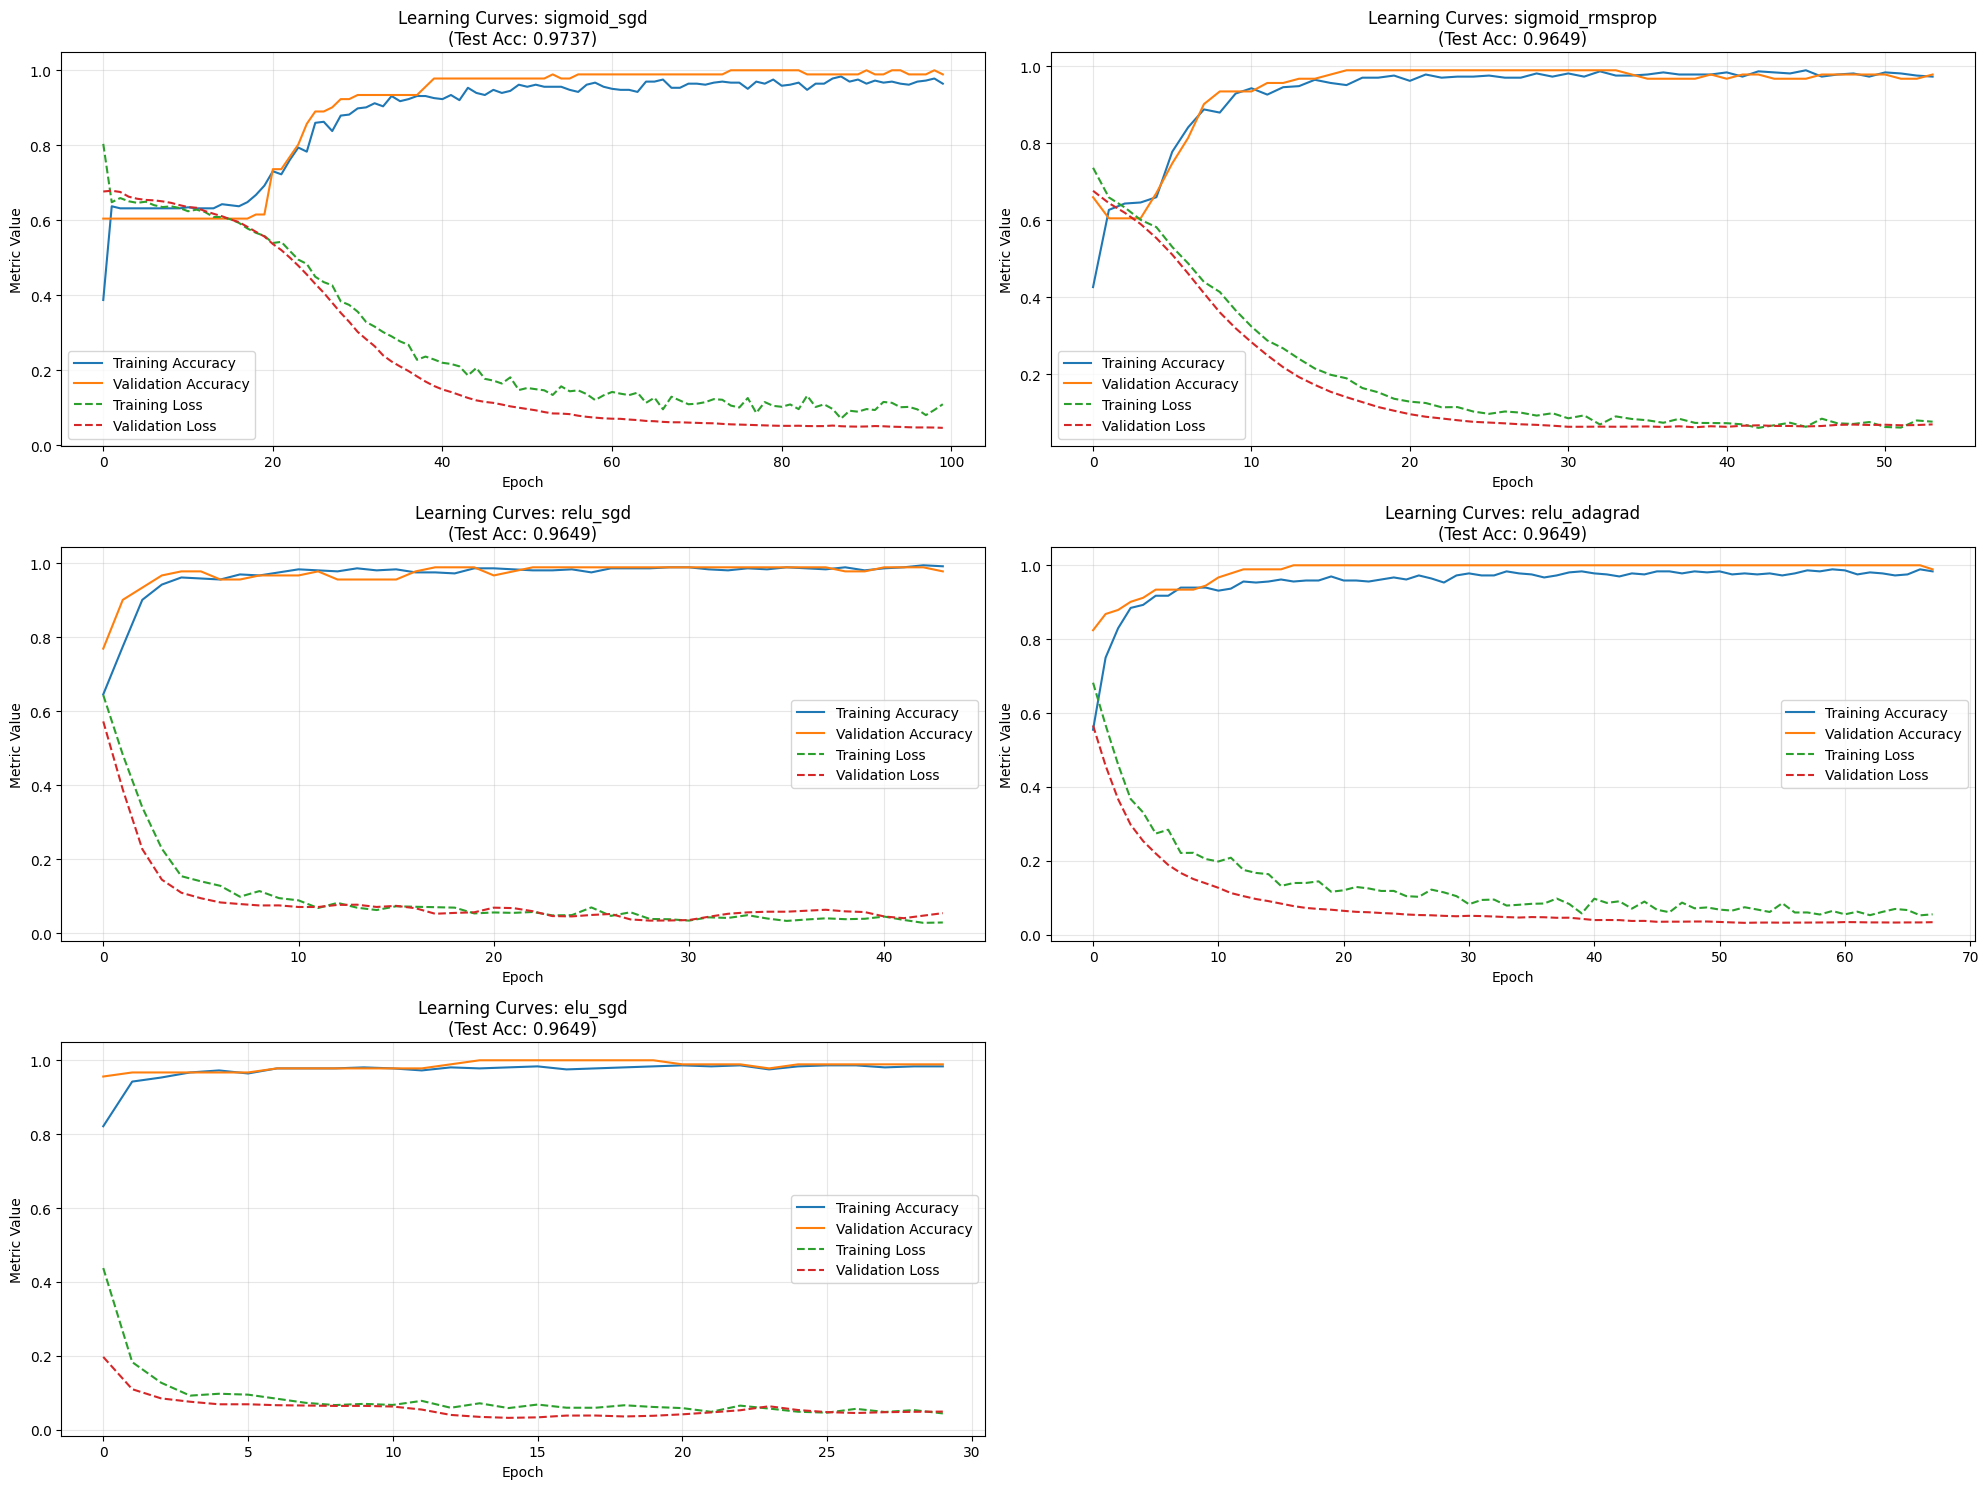

In [43]:
top_models = results_df.head(5).index

plt.figure(figsize=(20, 15))

for i, model_name in enumerate(top_models, 1):
    plt.subplot(3, 2, i)

    history = history_data[model_name]

    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history['loss'], label='Training Loss', linestyle='--')
    plt.plot(history['val_loss'], label='Validation Loss', linestyle='--')

    plt.title(f'Learning Curves: {model_name}\n(Test Acc: {results[model_name]["test_accuracy"]:.4f})')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

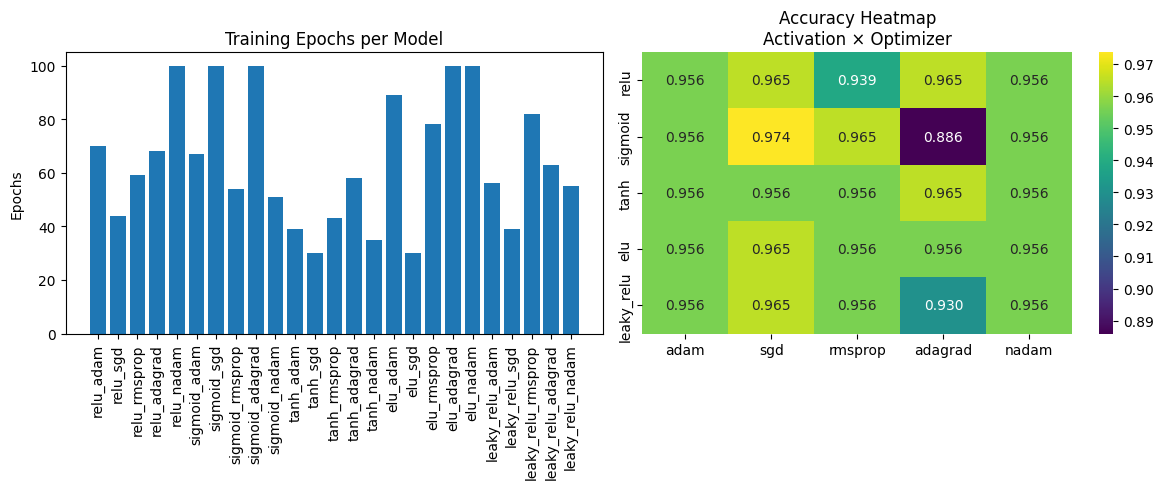

In [44]:
plt.figure(figsize=(12, 5))

# Plot 1: Training epochs
plt.subplot(1, 2, 1)
model_names = list(results.keys())
epoch_counts = [len(history_data[model]['accuracy']) for model in model_names]

plt.bar(model_names, epoch_counts)
plt.xticks(rotation=90)
plt.title('Training Epochs per Model')
plt.ylabel('Epochs')

# Plot 2: Accuracy heatmap
plt.subplot(1, 2, 2)
accuracy_matrix = np.zeros((len(activation_functions), len(optimizers)))
for i, activation in enumerate(activation_functions):
    for j, optimizer in enumerate(optimizers.keys()):
        model_name = f"{activation}_{optimizer}"
        if model_name in results:
            accuracy_matrix[i, j] = results[model_name]['test_accuracy']

sns.heatmap(accuracy_matrix,
            xticklabels=optimizers.keys(),
            yticklabels=activation_functions,
            annot=True, fmt='.3f', cmap='viridis')
plt.title('Accuracy Heatmap\nActivation × Optimizer')

plt.tight_layout()
plt.show()